In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from random import sample
%matplotlib inline

DIR = 'data'

In [17]:
# Reading names
words = open(f'{DIR}/names.txt').read().splitlines()
words[:5]

['ieretha', 'bruni', 'bran', 'rachoisa', 'marry']

In [18]:
symbols = sorted(list(set(''.join(words))))
num_of_symbols = 1 + len(symbols)   # adding '.' to the vocab
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [19]:
stoi = {ch: i + 1 for i, ch in enumerate(symbols)}
stoi['.'] = 0

itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'y', 0: '.'}


### Building dataset
_block_size_: context length (how many previous characters are considered in the prediction) 

_X_: neural net inputs 

_Y_: neural net input labels

In [20]:
block_size = 3
X, Y = [], []

In [21]:
def train_test_split(X: torch.tensor, Y: torch.tensor, p: float):
    train_size = int(p * X.shape[0])

    idxs = set([i for i in range(X.shape[0])])
    train_idxs = set(sample(idxs, k=train_size))
    test_idxs = idxs - train_idxs

    train_idxs, test_idxs = list(train_idxs), list(test_idxs)
    return X[train_idxs], Y[train_idxs], X[test_idxs], Y[test_idxs]

In [22]:
for name in words:
    context = [0] * block_size
    for ch in name + '.':
        idx = stoi[ch]
        X.append(context)
        Y.append(idx)

        # context update
        context = context[1:] + [idx] 

X, Y = torch.tensor(X), torch.tensor(Y)

In [23]:
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, 0.8)

/tmp/ipykernel_3196/1926032739.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_idxs = set(sample(idxs, k=train_size))


### Parameters

In [30]:
# Hyperparameters
emb_dimensions = 10
num_of_neurons = 100 
hl_input_length = block_size * emb_dimensions

minibatch_size = 32
num_of_epochs = 100000

## NN parameters
C = torch.randn((num_of_symbols, emb_dimensions))
W1 = torch.randn((hl_input_length, num_of_neurons)) 
b1 = torch.randn(num_of_neurons)
W2 = torch.randn((num_of_neurons, num_of_symbols))
b2 = torch.randn(num_of_symbols)

In [31]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

### Model Training

In [32]:
lre = torch.linspace(-3, 0, num_of_epochs)
lrs = 10**lre

In [33]:
# Once the learning rates were evaluated, we choose a good one
lr = 10**-1

In [34]:
losses = []

In [35]:
# Stochastic Gradient Descent
for i in range(num_of_epochs):
    idx = torch.randint(0, X_train.shape[0], (minibatch_size,))

    """ Forward pass """
    emb = C[X_train[idx]]
    h = torch.tanh(emb.view(-1, hl_input_length) @ W1 + b1) # hidden layer
    logits = h @ W2 + b2                                    # output layer
    loss = F.cross_entropy(logits, Y_train[idx])            # loss
    losses.append(loss.log10().item())

    print(f"epoch {i}, {loss=}")

    """ Backward pass """
    for p in parameters:
        p.grad = None
    loss.backward()

    """ Update """
    lr = lr/2 if i == num_of_epochs//2 else lr 
    for p in parameters:
        p.data += -lr * p.grad

epoch 0, loss=tensor(28.8786, grad_fn=<NllLossBackward0>)
epoch 1, loss=tensor(26.5587, grad_fn=<NllLossBackward0>)
epoch 2, loss=tensor(26.9830, grad_fn=<NllLossBackward0>)
epoch 3, loss=tensor(21.9818, grad_fn=<NllLossBackward0>)
epoch 4, loss=tensor(24.2782, grad_fn=<NllLossBackward0>)
epoch 5, loss=tensor(20.6847, grad_fn=<NllLossBackward0>)
epoch 6, loss=tensor(19.0384, grad_fn=<NllLossBackward0>)
epoch 7, loss=tensor(21.1725, grad_fn=<NllLossBackward0>)
epoch 8, loss=tensor(19.4511, grad_fn=<NllLossBackward0>)
epoch 9, loss=tensor(17.4299, grad_fn=<NllLossBackward0>)
epoch 10, loss=tensor(19.7859, grad_fn=<NllLossBackward0>)
epoch 11, loss=tensor(18.0978, grad_fn=<NllLossBackward0>)
epoch 12, loss=tensor(16.3347, grad_fn=<NllLossBackward0>)
epoch 13, loss=tensor(19.2436, grad_fn=<NllLossBackward0>)
epoch 14, loss=tensor(16.6467, grad_fn=<NllLossBackward0>)
epoch 15, loss=tensor(15.6976, grad_fn=<NllLossBackward0>)
epoch 16, loss=tensor(15.6489, grad_fn=<NllLossBackward0>)
epoch 1

### Searching for a good learning rate
Based on the first 1000 epochs, the learning rates used generated the following losses

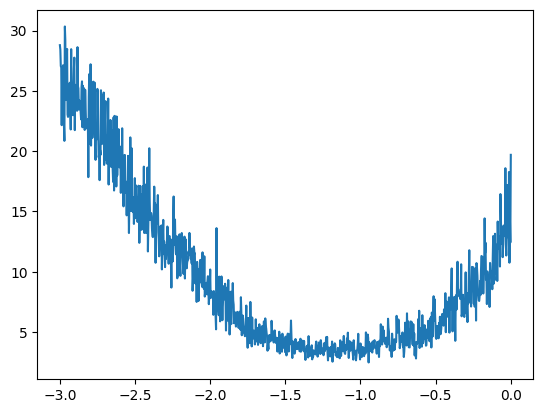

In [ ]:
plt.plot(lre, losses)

We can see that around $lr=-0.9$, the loss was at its lowest. Therefore, that value will be used for the training

### Loss curve

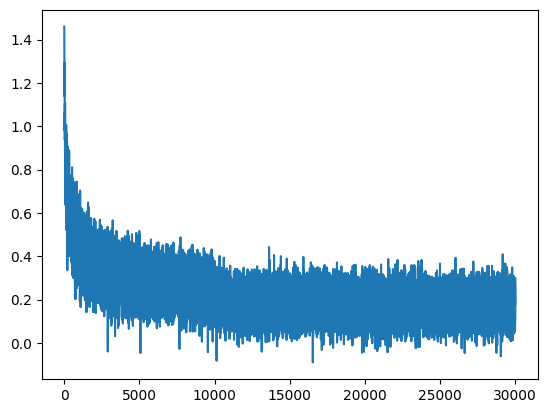

In [36]:
plt.plot(torch.arange(0, num_of_epochs), losses)

### Test loss

In [40]:
emb = C[X_test]
h = torch.tanh(emb.view(-1, hl_input_length) @ W1 + b1) # hidden layer
logits = h @ W2 + b2                                    # output layer
loss = F.cross_entropy(logits, Y_test)                  # loss
print(f"test loss: {loss.item()}")

test loss: 1.5464279651641846


### Sampling from the model

In [43]:
samples = []
for _ in range(10):
    idx, out = 0, ""
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [idx]
        if idx == 0:
            break

        out += itos[idx]
    samples.append(out)

print(samples)

['bagdrunssi', 'larra', 'bar', 'alise', 'danssi', 'pomi', 'isis', 'hel', 'birie', 'tumm']
